In [1]:
import numpy as np
import sys

sys.path.append('../code/')
from mlalgos import BiSequential
from mllib import Utilities,MLUtilities

from time import time
import pickle

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc

ut = Utilities()
ml = MLUtilities()

In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14 # 14
mpl.rcParams['legend.labelspacing'] = 0.25
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

# Example usage of `BiSequential`

### Load existing network

In [3]:
# define location stem relative to current working directory
File_Stem = 'binet/biNN2p' 
print('Using file stem:',File_Stem)

start_time = time()
print('... loading bi-sequential network')

# read setup parameters
with open(File_Stem + '.pkl', 'rb') as f:
    params_setup = pickle.load(f)

# initialize class
binet = BiSequential(params=params_setup)

# load network parameters from files
binet.load()

# print out total number of network parameters optimized
print('... no. of free params optimized = {0:d}'.format(binet.calc_N_freeparams()))

# read training parameters used for optimization
with open(File_Stem + '_train.pkl', 'rb') as f:
    params_train = pickle.load(f)
print('... training params:',params_train)

ut.time_this(start_time)

Using file stem: binet/biNN2p
... loading bi-sequential network
Setting up 20,6 layer feed-forward bi-neural network
... ... expecting data dim = 1, theta dim = 2, output dim = 1
... ... NNa using hidden layers of sizes [8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8]
... ... ... and activations [relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,tanh,tanh,tanh,tanh,tanh]
... ... NNw using hidden layers of sizes [3,3,3,3,3,9]
... ... ... and activations [tanh,tanh,tanh,tanh,tanh,tanh]
... ... using loss function 'square'
... ... not using any regularization
... ... not using any weight decay in NNa
... ... not using any weight decay in NNw
... no. of free params optimized = 1477
... training params: {'max_epoch': 1000000, 'mb_count': 158, 'val_frac': 0.2, 'check_after': 1000, 'lrate_a': 3e-06, 'lrate_w': 1e-05}
0 min 0.00 seconds



### Extract and plot basis functions

Extracting basis functions as NN...
... extracting basis functions from NNa
... setting up 20 layer feed-forward neural network
... ... expecting data dim = 1, target dim = 8
... ... using hidden layers of sizes [8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8]
... ... ... and activations [relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,tanh,tanh,tanh,tanh]
... ... using last activation layer 'tanh'
... ... ... with threshold (None means default): None
... ... using loss function 'square'
... ... not using any regularization
... ... not using any weight decay
... done
Evaluating 9 basis functions...
... done


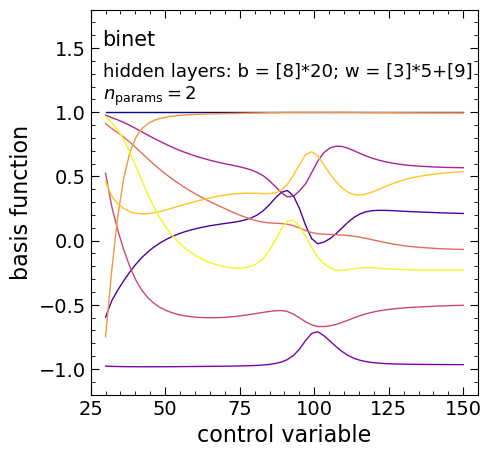

0 min 0.18 seconds



In [4]:
start_time = time()
print('Extracting basis functions as NN...')
basis = binet.extract_basis()
n_basis = basis.n_layer[-1]+1 # +1 for constant
print('... done')

print('Evaluating {0:d} basis functions...'.format(n_basis))
# setup control variable
s_min,s_max = 30.0,150.0 # min,max values, should be consistent with training
n_s_extract = 60
svals_extract = np.linspace(s_min,s_max,n_s_extract) 

# evaluate basis functions
basis_func = basis.predict(ml.rv(svals_extract))
basis_func = np.concatenate((ml.rv([1.0]*n_s_extract),basis_func),axis=0) # account for constant
# basis_func has shape (n_basis,n_s_extract)
# basis_func.T is design matrix M of linear Gaussian problem
print('... done')

# plot
FSize = 5
plt.figure(figsize=(FSize,FSize))
plt.ylim(-1.2,1.8)
plt.xlim(25,155)
plt.xlabel('control variable')
plt.ylabel('basis function')
cols = iter(plt.cm.plasma(np.linspace(0,1,n_basis)))
for b in range(n_basis):
    col = next(cols)
    plt.plot(svals_extract,svals_extract**0*basis_func[b],'-',color=col,lw=1)
plt.text(29,1.52,'binet',fontsize=FS2)
layering = 'hidden layers: '
layering += 'b = [{0:d}]*{1:d}; '.format(params_setup['n_layer_a'][0],params_setup['La'])
if params_setup['Lw'] > 1:
    layering += 'w = [{0:d}]*{1:d}+[{2:d}]'.format(params_setup['n_layer_w'][0],params_setup['Lw']-1,params_setup['n_layer_w'][-1])
else:
    layering += 'w = [{0:d}]'.format(params_setup['n_layer_w'][0])
plt.text(29,1.28,layering,fontsize=FS3)
plt.text(29,1.1,'$n_{{\\rm params}} = {0:d}$'.format(int(File_Stem[-2])),fontsize=FS3)
plt.minorticks_on()
plt.show()

ut.time_this(start_time)

### Extract coefficients

Extracting coefficients as NN...
... extracting coefficients from NNw
... setting up 6 layer feed-forward neural network
... ... expecting data dim = 2, target dim = 9
... ... using hidden layers of sizes [3,3,3,3,3]
... ... ... and activations [tanh,tanh,tanh,tanh,tanh]
... ... using last activation layer 'tanh'
... ... ... with threshold (None means default): None
... ... using loss function 'square'
... ... not using any regularization
... ... not using any weight decay
... done


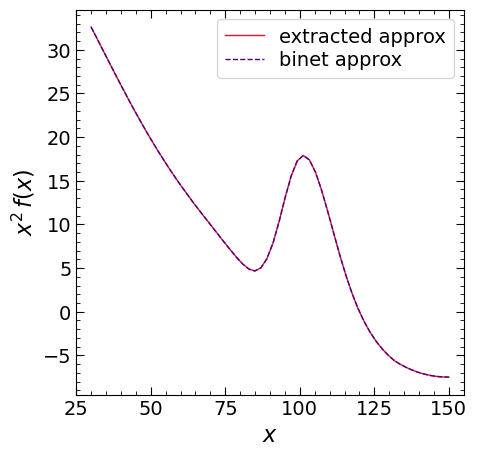

0 min 0.12 seconds



In [6]:
start_time = time()
print('Extracting coefficients as NN...')
coeffs = binet.extract_coeffs()
print('... done')

# choose parameter column-vector (should be consistent with expected input dimension and training range)
theta = ml.cv([0.3153,0.6737])

# evaluate coefficients
coeff_vec = coeffs.predict(theta) # shape (n_basis,1)
if binet.standardize:
    # modify coefficients to account for original standardization
    coeff_vec *= (binet.Y_std + 1e-15)
    coeff_vec[0] += binet.Y_mean

# evaluate function approximation
approx = np.dot(basis_func.T,coeff_vec).squeeze()

# evaluate function approximation directly from BiSequential instance
X_train = np.zeros((n_s_extract,2+1)) # features = cosmo params + separation; X will be transposed below
X_train[:,0] = theta[0,0]
X_train[:,1] = theta[1,0]
X_train[:,-1] = svals_extract
X_train = X_train.T
predicted = binet.predict(X_train)[0]

# plot
FSize = 5
plt.figure(figsize=(FSize,FSize))
# plt.ylim(-1.2,1.8)
plt.xlim(25,155)
plt.xlabel('$x$')
plt.ylabel('$x^{{2}}\\,f(x)$')
plt.plot(svals_extract,svals_extract**2*approx,'-',color='crimson',lw=1,label='extracted approx')
plt.plot(svals_extract,svals_extract**2*predicted,'--',color='indigo',lw=1,label='binet approx')
plt.legend(loc='upper right')
plt.minorticks_on()
plt.show()

ut.time_this(start_time)